In [84]:
# !pip install transformers datasets scikit-learn pandas torch
# !pip install accelerate

In [85]:
# !pip uninstall -y transformers
# !pip install transformers


In [86]:
# !pip install transformers[torch] --force-reinstall

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments,TrainerCallback, EarlyStoppingCallback

In [88]:
# Load train and test data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [89]:
print(train_df.head())
print(test_df.head())

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0
   id                                               text
0   0  ETF assets to surge tenfold in 10 years to $50...
1   1  Here’s What Hedge Funds Think Evolution Petrol...
2   2  $PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3   3  China is in the process of waiving retaliatory...
4   4  Highlight: “When growth is scarce, investors s...


We perform basic data preprocessing that was applied in the preprocessing file as well, the only difference is that we do not remove non-alphanumeric characters becuase we want to preserve emojis, punctuation, and special characters - thats how GPT2 was trained.

In [90]:
def clean_text_gpt2(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [91]:
# Applying the preprocessing
train_df['text'] = train_df['text'].apply(clean_text_gpt2)
test_df['text'] = test_df['text'].apply(clean_text_gpt2)

In [92]:
# Prepare GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT2 has no pad token so we have to implement as well to ensure that every

In [93]:
# Spliting train into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df['label'].tolist()
)

In [94]:
# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=128)

In [95]:
# Dataset class
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [96]:
from transformers import TrainerCallback

# Custom callback to store losses and metrics
class LossAndMetricsLogger(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.eval_f1s = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.eval_accuracies.append(logs['eval_accuracy'])
            if 'eval_f1' in logs:
                self.eval_f1s.append(logs['eval_f1'])

logger = LossAndMetricsLogger()

In [97]:
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings)

In [98]:
# Load GPT2 decoder model for classification (we have three labels 0,1,2)
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

model.config.hidden_dropout_prob = 0.3
model.config.attn_pdrop = 0.3
model.config.embd_pdrop = 0.3

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
# Evaluation Metrics - we are using macrof1 score because our labels are inbalanced
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [105]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    learning_rate=5e-5,
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1", # we are considering macro f1 score for evaluation of the best model
    save_total_limit=1
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger, EarlyStoppingCallback(early_stopping_patience=2)]
)

In [106]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.336000,0.478218,0.834992,0.790465,0.781947,0.803962
2,0.364700,0.430558,0.858565,0.808546,0.832378,0.792220
3,0.434600,0.693705,0.848612,0.803426,0.800731,0.807235
4,0.095900,0.893581,0.844945,0.808093,0.789299,0.831992


TrainOutput(global_step=3820, training_loss=0.38697695289957895, metrics={'train_runtime': 902.5077, 'train_samples_per_second': 84.587, 'train_steps_per_second': 10.582, 'total_flos': 1589572307017728.0, 'train_loss': 0.38697695289957895, 'epoch': 4.0})

In [107]:
# Evaluate
results = trainer.evaluate()
print("Validation Results:", results)

# Predict on test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

Validation Results: {'eval_loss': 0.4305581748485565, 'eval_accuracy': 0.8585646935568361, 'eval_f1': 0.8085464604152129, 'eval_precision': 0.8323781565265632, 'eval_recall': 0.7922200799021187, 'eval_runtime': 8.4953, 'eval_samples_per_second': 224.712, 'eval_steps_per_second': 28.133, 'epoch': 4.0}


In [108]:
# File with test label for submission
test_df['label'] = preds
test_df[['id','label']].to_csv("pred_decoder.csv", index=False)

print("Prediction file saved as pred_decoder.csv")

Prediction file saved as pred_decoder.csv


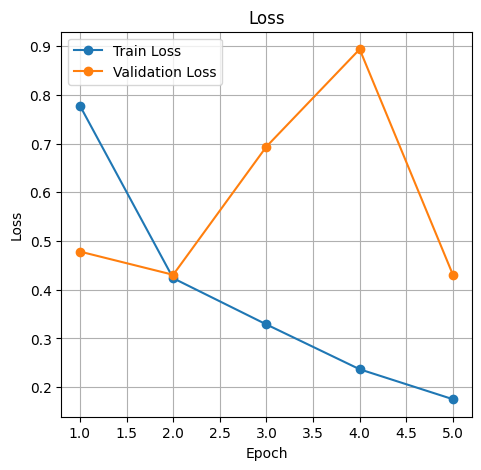

In [110]:
# Calculate train losses per epoch
train_steps_per_epoch = len(logger.train_losses) // len(logger.eval_losses)
train_losses_epoch = [
    np.mean(logger.train_losses[i*train_steps_per_epoch : (i+1)*train_steps_per_epoch])
    for i in range(len(logger.eval_losses))
]
epochs = range(1, len(logger.eval_losses) + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_epoch, label="Train Loss", marker='o')
plt.plot(epochs, logger.eval_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)
